An implementation of GloVe (Global vectors for word representation)

In [2]:
import nltk
from collections import Counter
from itertools import combinations_with_replacement
from tqdm import tqdm
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from IPython import display

In [3]:
torch.manual_seed(2345678)

# Load data using the NLTK corpus

In [4]:
nltk.corpus.gutenberg.fileids() # Show all texts in the Gutenberg corpus in the NLTK

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

Build the word to index mapping

In [5]:
# Select the melville-moby_dick.txt as the training sample
melville_words = nltk.corpus.gutenberg.words('melville-moby_dick.txt')[:500]

# Lower all words
vocab = list(set([w.lower() for w in melville_words]))

# Show the first five words in the processed list 
print(vocab[:5])
print(f'Total words in the text: {len(vocab)}')

['at', 'which', 'anglo', 'more', 'danish']
Total words in the text: 258


# Build co-occurence blobs (the $X_{ij}$ values)

Build a word co-occurrence list for the given corpus, where each element (representing
a cooccurrence pair) is of the form $(i_{id}, j_{id}, X_{ij})$, where 
$i_{id}$   : the ID of the main word in the cooccurrence;
$j_{id}$: the ID of the context word;
$X_{ij}$: the the cooccurrence value

In [6]:
melville_sents = nltk.corpus.gutenberg.sents('melville-moby_dick.txt')[:500]
melville_sents = [[w.lower() for w in s] for s in melville_sents]

for sent in melville_sents[:5]:
    print(sent)

['[', 'moby', 'dick', 'by', 'herman', 'melville', '1851', ']']
['etymology', '.']
['(', 'supplied', 'by', 'a', 'late', 'consumptive', 'usher', 'to', 'a', 'grammar', 'school', ')']
['the', 'pale', 'usher', '--', 'threadbare', 'in', 'coat', ',', 'heart', ',', 'body', ',', 'and', 'brain', ';', 'i', 'see', 'him', 'now', '.']
['he', 'was', 'ever', 'dusting', 'his', 'old', 'lexicons', 'and', 'grammars', ',', 'with', 'a', 'queer', 'handkerchief', ',', 'mockingly', 'embellished', 'with', 'all', 'the', 'gay', 'flags', 'of', 'all', 'the', 'known', 'nations', 'of', 'the', 'world', '.']


In [7]:
flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten(melville_sents)))

# Mark each word in the vocab list by its index
word2index = {word:index for index, word in enumerate(vocab)}
# print(word2index)

# Also build the integer to word list
index2word = {index:word for word, index in word2index.items()}
# print(index2word)

In [8]:
# Insert each sentence with <S> at the begining and append <E> at the end
WINDOW_SIZE = 5
_sents = [['<S>'] * WINDOW_SIZE + s + ['<E>'] * WINDOW_SIZE for s in melville_sents]

for s in _sents[:5]:
    print(s)

['<S>', '<S>', '<S>', '<S>', '<S>', '[', 'moby', 'dick', 'by', 'herman', 'melville', '1851', ']', '<E>', '<E>', '<E>', '<E>', '<E>']
['<S>', '<S>', '<S>', '<S>', '<S>', 'etymology', '.', '<E>', '<E>', '<E>', '<E>', '<E>']
['<S>', '<S>', '<S>', '<S>', '<S>', '(', 'supplied', 'by', 'a', 'late', 'consumptive', 'usher', 'to', 'a', 'grammar', 'school', ')', '<E>', '<E>', '<E>', '<E>', '<E>']
['<S>', '<S>', '<S>', '<S>', '<S>', 'the', 'pale', 'usher', '--', 'threadbare', 'in', 'coat', ',', 'heart', ',', 'body', ',', 'and', 'brain', ';', 'i', 'see', 'him', 'now', '.', '<E>', '<E>', '<E>', '<E>', '<E>']
['<S>', '<S>', '<S>', '<S>', '<S>', 'he', 'was', 'ever', 'dusting', 'his', 'old', 'lexicons', 'and', 'grammars', ',', 'with', 'a', 'queer', 'handkerchief', ',', 'mockingly', 'embellished', 'with', 'all', 'the', 'gay', 'flags', 'of', 'all', 'the', 'known', 'nations', 'of', 'the', 'world', '.', '<E>', '<E>', '<E>', '<E>', '<E>']


In [9]:
# Construct the ngrams for building word pairs (i, j) 
windows = flatten([list(nltk.ngrams(s, WINDOW_SIZE * 2 + 1)) for s in _sents])

for s in windows[:20]:
    print(s)

('<S>', '<S>', '<S>', '<S>', '<S>', '[', 'moby', 'dick', 'by', 'herman', 'melville')
('<S>', '<S>', '<S>', '<S>', '[', 'moby', 'dick', 'by', 'herman', 'melville', '1851')
('<S>', '<S>', '<S>', '[', 'moby', 'dick', 'by', 'herman', 'melville', '1851', ']')
('<S>', '<S>', '[', 'moby', 'dick', 'by', 'herman', 'melville', '1851', ']', '<E>')
('<S>', '[', 'moby', 'dick', 'by', 'herman', 'melville', '1851', ']', '<E>', '<E>')
('[', 'moby', 'dick', 'by', 'herman', 'melville', '1851', ']', '<E>', '<E>', '<E>')
('moby', 'dick', 'by', 'herman', 'melville', '1851', ']', '<E>', '<E>', '<E>', '<E>')
('dick', 'by', 'herman', 'melville', '1851', ']', '<E>', '<E>', '<E>', '<E>', '<E>')
('<S>', '<S>', '<S>', '<S>', '<S>', 'etymology', '.', '<E>', '<E>', '<E>', '<E>')
('<S>', '<S>', '<S>', '<S>', 'etymology', '.', '<E>', '<E>', '<E>', '<E>', '<E>')
('<S>', '<S>', '<S>', '<S>', '<S>', '(', 'supplied', 'by', 'a', 'late', 'consumptive')
('<S>', '<S>', '<S>', '<S>', '(', 'supplied', 'by', 'a', 'late', 'consu

In [10]:
# Building word pairs
word_pairs = []

for window in windows:
    for i in range(WINDOW_SIZE * 2 + 1):
        # Center at the word at index WINDOW_SIZE (which is at index 5), denoted as i
        # Ignore <S> and <E> and the word i itself, all other words in the windows are context, denoted as j 
        # Then make the pair in the form as (i, j)
        if i == WINDOW_SIZE or window[i] == '<S>' or window[i] == '<E>': 
            continue
        word = window[WINDOW_SIZE]
        context = window[i]
        word_pairs.append((word, context))    

In [11]:
print(word_pairs[:10])

[('[', 'moby'), ('[', 'dick'), ('[', 'by'), ('[', 'herman'), ('[', 'melville'), ('moby', '['), ('moby', 'dick'), ('moby', 'by'), ('moby', 'herman'), ('moby', 'melville')]


Build co-occurence matrix $X$ 

In [12]:
# Record the occurence time of each word in the corpus, denoted as X_i
X_i = Counter(flatten(melville_sents))

# Record the co-occurence time of each word within window_size using onstructed word pairs 
X_ik_window = Counter(word_pairs)

In [13]:
# X_i

In [14]:
# X_ik_window

In [15]:
X_ik = {}
weighting_dict = {}

In [16]:
# All the possible subsets or arrangements of the iterator
# Elements are allowed to repeat in a subset because of the word 'replacement'
# In fact, combinations_with_replacement(vocab, 2) is a matrix with size len(vocab) x len(vocab)
# The following line list the first five samples  
vocab_mat = list(combinations_with_replacement(vocab, 2))

In [17]:
print(vocab_mat[:5])

[('good', 'good'), ('good', 'tapered'), ('good', 'thick'), ('good', 'which'), ('good', 'deeper')]


Compute the weighting function

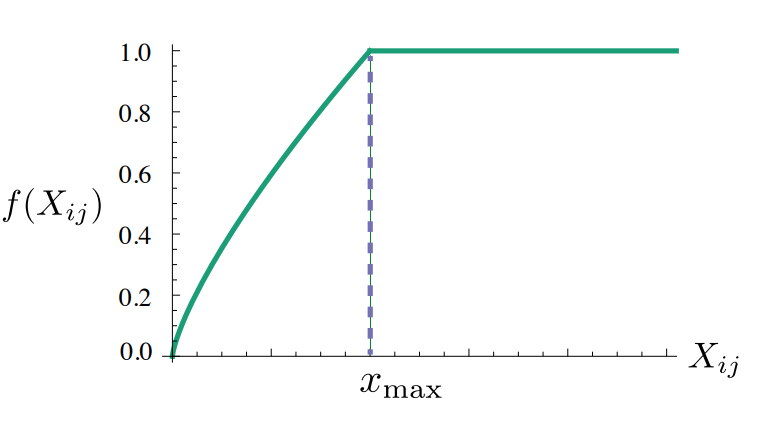

In [20]:
display.Image('imgs/glove-weighting-function.png')

In [18]:
def weighting(w_i, w_j):
    # Define the weighting function in the above figure
    try:
        x_ij = X_ik[(w_i, w_j)]
    except:
        x_ij = 1
        
    x_max = 100 #100 # fixed in paper
    alpha = 0.75
    
    if x_ij < x_max:
        result = (x_ij/x_max)**alpha
    else:
        result = 1
    
    return result

In [19]:
for i in tqdm(range(len(vocab_mat))):
    pair = vocab_mat[i]
    if X_ik_window.get(pair) is not None: # If the pair exists in text (sentence)
        co_occur = X_ik_window[pair]      # Get its co-occurence time
        X_ik[(pair[0], pair[1])] = co_occur + 1 # log(Xik) -> log(Xik+1) to prevent divergence
        X_ik[(pair[1], pair[0])] = co_occur + 1 # Symmetry 
    else: # If the pair not exist, then do nothing
        pass

    # Compute the weight of the pair, symmetrically
    weighting_dict[(pair[0], pair[1])] = weighting(pair[0], pair[1])
    weighting_dict[(pair[1], pair[0])] = weighting(pair[1], pair[0])

100%|██████████| 3399528/3399528 [00:12<00:00, 280509.34it/s]


# Prepare dataset

In [22]:
word = []
context = []
co_occur = []
weights = []

for i in tqdm(range(len(word_pairs))):
    pair = word_pairs[i] # Take the word pair in the dataset
    
    # Convert the word into a tensor after integer representation
    word.append(torch.tensor(word2index[pair[0]], device='cuda').view(1, -1))
    context.append(torch.tensor(word2index[pair[1]], device='cuda').view(1, -1))

    try:
        co_occur_count = torch.tensor([X_ik[pair]], device='cuda').view(1, -1)
    except:
        co_occur_count = torch.tensor([1.0], device='cuda').view(1, -1)
    
    # Record the log of the co-occurence and the weight of the pair
    co_occur.append(torch.log(co_occur_count))
    weights.append(torch.tensor([weighting_dict[pair]], device='cuda').view(1, -1))

# Gather all four list together as the training data
train_data = list(zip(word, context, co_occur, weights))

100%|██████████| 88414/88414 [00:32<00:00, 2750.10it/s]


In [23]:
print(word_pairs[0])
print(train_data[0])

('[', 'moby')
(tensor([[2264]], device='cuda:0'), tensor([[787]], device='cuda:0'), tensor([[0.6931]], device='cuda:0'), tensor([[0.0532]], device='cuda:0'))


# Build the model

In [24]:
class GloVe(nn.Module):
    
    def __init__(self, vocab_size, projection_dim):
        super(GloVe, self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, projection_dim) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, projection_dim) # out embedding
        
        self.v_bias = nn.Embedding(vocab_size, 1)
        self.u_bias = nn.Embedding(vocab_size, 1)
        
        initrange = (2.0 / (vocab_size + projection_dim))**0.5 # Xavier init
        self.embedding_v.weight.data.uniform_(-initrange, initrange) # init
        self.embedding_u.weight.data.uniform_(-initrange, initrange) # init
        self.v_bias.weight.data.uniform_(-initrange, initrange) # init
        self.u_bias.weight.data.uniform_(-initrange, initrange) # init
        
    def forward(self, center_words, target_words, coocs, weights):
        center_embeds = self.embedding_v(center_words) # B x 1 x D
        target_embeds = self.embedding_u(target_words) # B x 1 x D
        
        center_bias = self.v_bias(center_words).squeeze(1)
        target_bias = self.u_bias(target_words).squeeze(1)
        
        inner_product = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2) # Bx1
        
        loss = weights * torch.pow(inner_product + center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)
    
    def prediction(self, inputs):
        v_embeds = self.embedding_v(inputs) # B x 1 x D
        u_embeds = self.embedding_u(inputs) # B x 1 x D
                
        return v_embeds + u_embeds # final embed

Train the model

In [25]:
EMBEDDING_SIZE = 50
BATCH_SIZE = 256
EPOCH = 50

In [26]:
losses = []
model = GloVe(len(word2index), EMBEDDING_SIZE)
if torch.cuda.is_available():
    model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [27]:
def get_batch(batch_size, train_data):
    random.shuffle(train_data) # Shuffle all samples in the dataset
    start_index = 0     
    end_index = batch_size

    while end_index < len(train_data):
        # Slide samples from start_index to end_index
        batch = train_data[start_index:end_index]
        # Update start and end index to point to the next batch
        temp = end_index
        end_index += batch_size
        start_index = temp
        yield batch # MUse yield to remember the index in the next calling
    
    if end_index >= len(train_data):
        batch = train_data[start_index:] # Get all rest of samples to be the batch
        yield batch

In [28]:
for epoch in range(EPOCH):
    for i, batch in enumerate(get_batch(BATCH_SIZE, train_data)):
        
        inputs, targets, coocs, weights = zip(*batch)
        
        inputs = torch.cat(inputs) # B x 1
        targets = torch.cat(targets) # B x 1
        coocs = torch.cat(coocs)
        weights = torch.cat(weights)
        model.zero_grad()

        loss = model(inputs, targets, coocs, weights)
        
        loss.backward()
        optimizer.step()
    
        losses.append(loss.data.tolist())
    if epoch % 10 == 0:
        print(f'{epoch}/{EPOCH}: mean loss = {np.mean(losses):.4f}')
        # print("Epoch : %d, mean_loss : %.02f" % (epoch, np.mean(losses)))
        losses = []

0/50: mean loss = 223.4563
10/50: mean loss = 2.8299
20/50: mean loss = 0.5576
30/50: mean loss = 0.1289
40/50: mean loss = 0.0454


# Test

In [29]:
def word_similarity(target, vocab, n_words):
    # Encode the target words
    target_V = model.prediction(torch.tensor(word2index[target], device='cuda'))

    similarities = []
    for i in range(len(vocab)):
        if vocab[i] == target: # Skip the word itself
            continue
        
        # Use other words for comparison and distance computation using cosine similarity
        vector = model.prediction(torch.tensor(word2index[vocab[i]], device='cuda'))
        cosine_sim = F.cosine_similarity(target_V, vector, 0).data.tolist()

        similarities.append([vocab[i], cosine_sim])
    
    # Return the most similar n_words according to the cosine similarity
    return sorted(similarities, key=lambda x: x[1], reverse=True)[:n_words]

In [30]:
test = random.choice(vocab)
print(f'Random choose: {test}')
print(f'10 most related words:')
for pred in word_similarity(test, vocab, 10):
    print(pred)

Random choose: trackless
10 most related words:
['region', 0.7679055333137512]
['waste', 0.7401389479637146]
['instincts', 0.7073946595191956]
['exactly', 0.6137794256210327]
['satisfaction', 0.5967038869857788]
['mansoul', 0.5879079103469849]
['chewing', 0.5660055875778198]
['dusky', 0.5576773285865784]
['pine', 0.5464534163475037]
['landscape', 0.541761040687561]
